# High Performance Data Analysis with Big HDF5 Files in Python

*18/12/2017 - Giacomo Debidda @PyData Munich*

In [55]:
import os
import numpy as np
import pandas as pd
import h5py
import tables as tb
import datashader as ds
import datashader.transfer_functions as tf

In [3]:
np.set_printoptions(precision=2, suppress=True)

### Topics

- HDF5
- HDF5 tools
- h5py
- PyTables

![First World (data) problems](img/first-world-problems-meme.jpg)

### HDF5: a filesystem in a file

![HDF5 structure](img/hdf5_structure.jpg)

Working with groups and group members is similar to working with directories and files in UNIX.

**/** root group (every HDF5 file has a root group)

**/foo** member of the root group called foo

**/foo/bar** member of the group foo called bar

### HDF5 in the Python data stack

![h5py - PyTables refactor](img/h5py-pytables-refactor.png)

In [9]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/hdf5-pydata-munich/data


In [19]:
%%time
df = pd.read_hdf(path_or_buf='data/NYC-yellow-taxis-january.h5', key='/yellow_2015_01')

CPU times: user 8.61 s, sys: 2.09 s, total: 10.7 s
Wall time: 10.8 s


In [20]:
df.shape

(12748986, 17)

In [15]:
# New York City x/y range (meters)
x_range = (-8242000, -8210000)
y_range = (4965000, 4990000)

In [16]:
%%time
cvs = ds.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'pickup_x', 'pickup_y',  ds.count('passenger_count'))
img = tf.shade(agg, cmap=['#deebf7','#9ecae1','#3182bd'], how='log')

CPU times: user 140 ms, sys: 8 ms, total: 148 ms
Wall time: 149 ms


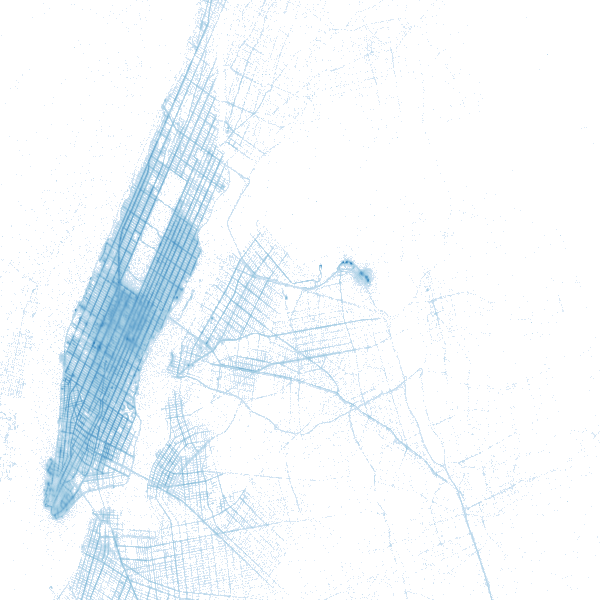

In [17]:
img

---

# h5py

The h5py library is a thin, pythonic wrapper around the HDF5 C API.

It tries to expose most of the functionality that the HDF5 library provides.

### Datasets

In [21]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_dataset(name='my_dataset', data=[1.0, 2.7, 3.7, 4.5])
#     f.create_dataset(name='my_other_dataset', data=[1, 2, 3, 4])
#     f.create_dataset(name='my_other_dataset', data=[1, 2, 3, 4], dtype=np.float32)

In [22]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    # the array is just a proxy object
    print(f['my_dataset'])
    # the actual data can be accessed with these 2 syntaxes
#     print(f['my_dataset'][:])
#     print(f['my_dataset'][...])

<HDF5 dataset "my_dataset": shape (4,), type "<f8">


### Preallocation on disk

In [23]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    dataset = f.create_dataset(name='my_dataset', shape=(8, 1))
    dataset[0] = 5.2
    dataset[1] = 7

### Pick the correct HDF5 datatype

In [24]:
arr = np.array([0, 1, 254, 255, 256, -1, -2], dtype='uint8')
print(arr)

[  0   1 254 255   0 255 254]


In [25]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_dataset(name='my_dataset', shape=(7,), dtype=h5py.h5t.STD_U8BE)
    f['my_dataset'][0:8] = [0, 1, 254, 255, 123456, -1, -2]
    print(f["my_dataset"][:])

[  0   1 254 255 255   0   0]


### Groups

In [26]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    f.create_group(name='group1')
    group2 = f.create_group(name='group2')
    group2.create_group(name='group3')

In [27]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    group3 = f['group2/group3']
    print(group3.parent)

<HDF5 group "/group2" (1 members)>


### Attributes

In [54]:
with h5py.File(name='data/my_h5py_file.h5', mode='w') as f:
    dataset = f.create_dataset(name='my_dataset', data=[1, 2, 3, 4])
    dataset.attrs['Unit'] = 'm/s'
    gr = f.create_group(name='my_group')
    gr.attrs['Created'] = '18/12/2017'
    gr.attrs.create(name='Versions', data=np.array([123, 456])) 

### Traverse a HDF5 file with h5py

In [29]:
with h5py.File(name='data/my_h5py_file.h5', mode='r') as f:
    f.visit(print)

my_dataset
my_group


### HDF5 Command Line Tools

[Here](https://support.hdfgroup.org/products/hdf5_tools/#h5dist) you can find the command line tools developed by the HDF Group. You don't need h5py or PyTables to use them.

If you are on Ubuntu, you can install them with `sudo apt install hdf5-tools`

In [30]:
# -r stands for 'recursive'
!h5ls -r 'data/my_h5py_file.h5'

/                        Group
/my_dataset              Dataset {4}
/my_group                Group


In [31]:
!h5dump 'data/my_h5py_file.h5'

HDF5 "data/my_h5py_file.h5" {
GROUP "/" {
   DATASET "my_dataset" {
      DATATYPE  H5T_STD_I64LE
      DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
      DATA {
      (0): 1, 2, 3, 4
      }
      ATTRIBUTE "Unit" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "m/s"
         }
      }
   }
   GROUP "my_group" {
      ATTRIBUTE "Created" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "18/12/2017"
         }
      }
      ATTRIBUTE "Versions" {
         DATATYPE  H5T_STD_I64LE
         DATASPACE  SIMPLE { ( 2 ) / ( 2 ) }
         DATA {
         (0): 123, 456
         }
      }
   }
}
}


---

# PyTables

PyTables provides a higher abstraction over HDF5. This doesn't make it slower than h5py though.

At the moment PyTables does **not** depend on h5py.

### Array


In [32]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where='/', 
                   name='my_array',
#                    title='My PyTables Array',
                   obj=[1, 2, 3, 4])

PyTables has a feature called "Natural Naming": nodes (i.e. datasets and groups in the HDF5 file) can be accessed with the dot notation.

In [33]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='r') as f:
    print(f.root.my_array)

/my_array (Array(4,)) ''


### Groups

In [34]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_group(where='/', name='my_group')

### Attributes

In [35]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where=f.root, name='my_array', obj=[1, 2, 3, 4], title='My PyTables Array')
    f.set_node_attr(where='/my_array', attrname='SomeAttribute', attrvalue='SomeValue')
    f.create_group(where='/', name='my_group')
    f.set_node_attr(where='/my_group', attrname='SomeOtherAttribute', attrvalue=123)

### HDF5 datasets have many abstractions in PyTables

Homogenous dataset:

- **Array**
- **CArray**
- **EArray**
- **VLArray**

Heterogenous dataset:

- **Table**

In [36]:
num_rows = 1000000  # 1 million
gaussian = np.random.normal(loc=0, scale=1, size=num_rows).astype('float32')
uniform = np.random.uniform(low=100, high=150, size=num_rows).astype('uint8')
num_columns = 5
matrix = np.random.random((num_rows, num_columns)).astype('float32')

### Array (again!)

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-array-class)

- Fastest I/O speed
- Homogeneous (i.e. data has same `dtype`)
- Must fit in memory
- Not compressible
- Not enlargeable

In [37]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_array(where='/', name='gaussian', obj=gaussian)
    f.create_array(where='/', name='uniform', obj=uniform)
    f.create_array(where='/', name='matrix', obj=matrix)

CPU times: user 8 ms, sys: 124 ms, total: 132 ms
Wall time: 177 ms


### CArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#carrayclassdescr)

- Chunked storage
- Data must be homogeneous
- Good speed when reading/writing
- Compressible
- Not enlargeable

In [38]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    # you can create a CArray and fill it later, but you need to specify atom and shape
    carray = f.create_carray(where='/', name='my_other_carray', atom=tb.Float32Atom(), shape=(4, 8))
    # later...
    carray[:, 1] = [5, 6, 7, 8]

In [39]:
filters = tb.Filters(complevel=5, complib='zlib')

Tips on how to use compression (from the PyTables docs)

- A mid-level (5) compression is sufficient. No need to go all the way up (9)
- Use zlib if you must guarantee complete portability
- Use blosc all other times (it is optimized for HDF5)

In [40]:
%%time
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    f.create_carray(where='/', name='gaussian', obj=gaussian, filters=filters)
    f.create_carray(where='/', name='uniform', obj=uniform, filters=filters)
    f.create_carray(where='/', name='matrix', obj=matrix, filters=filters)

CPU times: user 912 ms, sys: 104 ms, total: 1.02 s
Wall time: 1.02 s


### EArray

[Docs](http://www.pytables.org/usersguide/libref/homogenous_storage.html#earrayclassdescr)

- Enlargeable on **one** dimension (append)
- Pretty fast at extending, very good at reading
- Data must be homogeneous
- Compressible

In [41]:
%%time
# One (and only one) of the shape dimensions *must* be 0.
# The dimension being 0 means that the resulting EArray object can be extended along it.
# Multiple enlargeable dimensions are not supported right now.
shape = (num_rows, 0)

with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    earray = f.create_earray(where='/',
                             name='my_earray',
                             atom=tb.Float32Atom(),
                             shape=shape,
                             filters=filters)
    earray.append(sequence=matrix[:, 0:1])
    earray.append(sequence=matrix[:, 1:5])

CPU times: user 788 ms, sys: 68 ms, total: 856 ms
Wall time: 879 ms


### Table

[Docs](http://www.pytables.org/usersguide/libref/structured_storage.html?highlight=table#tableclassdescr)

- Data can be heterogeneous (i.e. different shapes and different dtypes)
- The structure of a table is declared by its description
- It supports *in-kernel* searches with `Table.where`
- It supports multi-column searches
- Non-nested columns can be *indexed*

In order to emulate in Python records mapped to HDF5 C structs PyTables implements a special class so as to easily define all its fields and other properties. It's called `IsDescription`.

A *description* defines the table structure (basically, the *schema* of your table).

In [42]:
class Particle(tb.IsDescription):
    identity = tb.StringCol(itemsize=22, dflt=' ', pos=0)  # character String
    idnumber = tb.Int16Col(dflt=1, pos=1)  # short integer

In [43]:
print(Particle.columns)

{'identity': StringCol(itemsize=22, shape=(), dflt=b' ', pos=0), 'idnumber': Int16Col(shape=(), dflt=1, pos=1)}


In [45]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    table = f.create_table(where='/', name='my_table', description=Particle)
    
    num_rows = 100
    row = table.row
    for i in range(num_rows):
        row['identity'] = 'I am {}'.format(i)
        row['idnumber'] = i
        row.append()
    # Flush the table buffers to release memory and make sure are written to disk
    table.flush()

In [48]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    table = f.create_table(where='/', name='my_table', description=Particle)

    for i in range(100):
        table.row['identity'] = 'I am {}'.format(i)
        table.row['idnumber'] = i
        table.row.append()
    table.flush()  # Flush the table buffers to release memory and make sure are written to disk

In [49]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='w') as f:
    table = f.create_table(where='/', name='my_table', description=Particle)
    
    for i in range(100):
        table.append([('I am {}'.format(i), i)])
        
    table.flush()  # Flush the table buffers to release memory and make sure are written to disk

### Traverse a HDF5 file with PyTables

In [50]:
with tb.open_file(filename='data/my_pytables_file.h5', mode='r') as f:
    for node in f.walk_nodes('/', classname='Table'):
        print('{}'.format(node._v_pathname))
        # are attributes nodes?
        # what is the reson for leaves?

/my_table


# NYC Yellow Taxi Dataset (2015)

### A quick look

Let's have a quick look at the data - without having to load into memory an entire 2GB CSV file - with the unix `less` command.

`less yellow_tripdata_2015-01.csv`

In these CSV files there are some changes from year to year. A few things I noticed:

- in the CSV files from 2014 there is a field called `pickup_datetime`. From January 2015 onwards this field has been renamed as `tpep_pickup_datetime`;
- starting from July 2016 the columns `pickup_longitude` and `pickup_latitude` have been replaced with `PULocationID`, and the columns `dropoff_longitude` and `dropoff_latitude` with `DOLocationID`.

### Read/Store the CSV files

These CSV files are huge! Don't forget the pandas [rule of thumb](http://wesmckinney.com/blog/apache-arrow-pandas-internals/):

> Have 5 to 10 times as much RAM as the size of your dataset.

On my laptop (Thinkpad X220 i5 10GB RAM) it took roughly:

- **40 minutes** to read/store a **single CSV**.

- **8 hours** to read/store an entire **year**.

<img src="https://i.imgflip.com/20fb1g.jpg" title="made at imgflip.com"/>

In [7]:
!h5ls 'data/NYC-yellow-taxis.h5'

yellow_2015_01           Dataset {12748986/Inf}
yellow_2015_02           Dataset {12450521/Inf}
yellow_2015_03           Dataset {13351609/Inf}
yellow_2015_04           Dataset {13071789/Inf}
yellow_2015_05           Dataset {13158262/Inf}
yellow_2015_06           Dataset {12324935/Inf}
yellow_2015_07           Dataset {11562783/Inf}
yellow_2015_08           Dataset {11130304/Inf}
yellow_2015_09           Dataset {11225063/Inf}
yellow_2015_10           Dataset {12315488/Inf}
yellow_2015_11           Dataset {11312676/Inf}
yellow_2015_12           Dataset {11460573/Inf}


PyTables is shipped with some useful command line utilities. These CLI utils are in `tables/utils`.

You can use them if you are working in a python environment where you installed PyTables (these CLI utils cause your python interpreter to execute a python script in `tables/scripts`).

In [38]:
!pttree --use-si-units --sort-by 'size' 'data/NYC-yellow-taxis.h5'


------------------------------------------------------------

/ (RootGroup)
+--yellow_2015_03 (Table)
|     mem=680.9MB, disk=312.9MB [ 9.3%]
+--yellow_2015_05 (Table)
|     mem=671.1MB, disk=307.0MB [ 9.1%]
+--yellow_2015_04 (Table)
|     mem=666.7MB, disk=305.5MB [ 9.1%]
+--yellow_2015_01 (Table)
|     mem=650.2MB, disk=294.6MB [ 8.7%]
+--yellow_2015_02 (Table)
|     mem=635.0MB, disk=290.5MB [ 8.6%]
+--yellow_2015_06 (Table)
|     mem=628.6MB, disk=287.7MB [ 8.5%]
+--yellow_2015_10 (Table)
|     mem=628.1MB, disk=280.0MB [ 8.3%]
+--yellow_2015_07 (Table)
|     mem=589.7MB, disk=262.6MB [ 7.8%]
+--yellow_2015_12 (Table)
|     mem=584.5MB, disk=260.7MB [ 7.7%]
+--yellow_2015_11 (Table)
|     mem=576.9MB, disk=257.5MB [ 7.6%]
+--yellow_2015_09 (Table)
|     mem=572.5MB, disk=255.6MB [ 7.6%]
`--yellow_2015_08 (Table)
      mem=567.6MB, disk=253.7MB [ 7.5%]

------------------------------------------------------------
Total branch leaves:    12
Total branch size:      7.5GB in memory, 3

![He Man I have the data](https://www.storegrowers.com/wp-content/uploads/2016/02/analytics-meme-sword-guy.png)

`table.read` reads the **entire table** (it must fit into memory) and query it with NumPy.

In [346]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    results = [x['total_amount'] for x in table.read() 
               if 1 < x['passenger_count'] < 4 and x['trip_distance'] > 0.5]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 2218407
CPU times: user 1min 22s, sys: 772 ms, total: 1min 23s
Wall time: 1min 23s


In [78]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.read()
    amounts = [row['total_amount'] for row in rows if row['passenger_count'] == 1]
    
print(len(amounts))

8993870
CPU times: user 1min, sys: 352 ms, total: 1min
Wall time: 1min


`table.iterrows` returns an **iterator** that iterates over all rows (so no need to load the entire table into memory).

In [8]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.iterrows()
    amounts = [row['total_amount'] for row in rows if row['passenger_count'] == 1]
    
print(len(amounts))

8993870
CPU times: user 6.9 s, sys: 552 ms, total: 7.45 s
Wall time: 8.15 s


In [41]:
condition = """((1 < passenger_count) & (passenger_count < 4)) & (trip_distance > 0.5)"""
# Of course you can make it more readable
# cond0 = '((1 < passenger_count) & (passenger_count < 4))'
# cond1 = '(trip_distance > 0.5)'
# condition = '{} & {}'.format(cond0, cond1)
# This won't work: you can't use Python's standard boolean operators in NumExpr expressions
# condition = """(1 < passenger_count < 4) & (trip_distance > 0.5)"""

In [80]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.read_where('passenger_count == 1')
    amounts = [x['total_amount'] for x in rows]
    
print(len(amounts))

8993870
CPU times: user 43.5 s, sys: 648 ms, total: 44.1 s
Wall time: 43.9 s


`table.where` uses **NumExpr** to make a **in-kernel** query.

In [82]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    rows = table.where('passenger_count == 1')
    results = [x['total_amount'] for x in rows]
    
print(len(amounts))

8993870
CPU times: user 8.6 s, sys: 256 ms, total: 8.85 s
Wall time: 8.71 s


### Add Indexes to the table

In [ ]:
with tb.open_file(filename='data/NYC-yellow-taxis.h5', mode='a') as f:
    table.cols.passenger_count.create_index

In [43]:
!h5ls 'data/NYC-yellow-taxis-indexed.h5'

_i_yellow_2015_01        Group
yellow_2015_01           Dataset {12748986/Inf}
yellow_2015_02           Dataset {12450521/Inf}
yellow_2015_03           Dataset {13351609/Inf}
yellow_2015_04           Dataset {13071789/Inf}
yellow_2015_05           Dataset {13158262/Inf}
yellow_2015_06           Dataset {12324935/Inf}
yellow_2015_07           Dataset {11562783/Inf}
yellow_2015_08           Dataset {11130304/Inf}
yellow_2015_09           Dataset {11225063/Inf}
yellow_2015_10           Dataset {12315488/Inf}
yellow_2015_11           Dataset {11312676/Inf}
yellow_2015_12           Dataset {11460573/Inf}


In [360]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where=table_where)
    results = [x['total_amount'] for x in table.read() 
               if 1 < x['passenger_count'] < 4 and x['trip_distance'] > 0.5]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 2218407
CPU times: user 1min 26s, sys: 860 ms, total: 1min 26s
Wall time: 1min 26s


In [44]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where=table_where)
    results = [x['total_amount'] for x in table.iterrows()
               if 1 < x['passenger_count'] < 4 and x['trip_distance'] > 0.5]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 2218407
CPU times: user 6.7 s, sys: 512 ms, total: 7.21 s
Wall time: 8.03 s


In [379]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where=table_where)
    results = [x['total_amount'] for x in table.read_where(condition)]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 2218407
CPU times: user 17.4 s, sys: 468 ms, total: 17.9 s
Wall time: 17.6 s


In [45]:
%%time
with tb.open_file(filename='data/NYC-yellow-taxis-indexed.h5', mode='r') as f:
    table = f.get_node(where=table_where)
    results = [x['total_amount'] for x in table.where(condition)]
    print('Rows that match the condition: {}'.format(len(results)))

Rows that match the condition: 2218407
CPU times: user 7.92 s, sys: 300 ms, total: 8.22 s
Wall time: 9.52 s


# Visualization

In [58]:
%%time
condition = """(passenger_count > 2) & (trip_distance > 10.5)"""
with tb.open_file(filename='data/NYC-yellow-taxis-january.h5', mode='r') as f:
    table = f.get_node(where='/yellow_2015_01')
    matches = [(x['pickup_x'], x['pickup_y'], x['passenger_count']) for x in table.where(condition)]

df_matches = pd.DataFrame(matches, columns=['pickup_x', 'pickup_y', 'passenger_count'])
print(df_matches.shape)

(83024, 3)
CPU times: user 8.97 s, sys: 244 ms, total: 9.22 s
Wall time: 8.98 s


In [59]:
cvs = ds.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)

agg1 = cvs.points(source=df, x='pickup_x', y='pickup_y', agg=ds.count('passenger_count'))
img1 = tf.shade(agg, cmap=['#deebf7','#9ecae1','#3182bd'], how='log')

agg2 = cvs.points(source=df_matches, x='pickup_x', y='pickup_y', agg=ds.count('passenger_count'))
img2 = tf.shade(agg2, cmap=['yellow', 'orange'], how='log')

img = tf.stack(img1, img2)

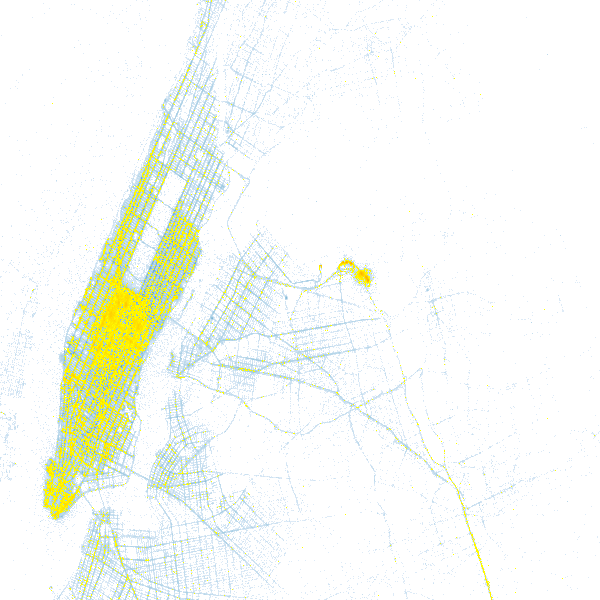

In [60]:
img

---

# Reference

- [Introduction to HDF5](https://www.youtube.com/watch?v=BAjsCldRMMc) by Quincey Koziol
- [HDF5 is Eating the World](https://www.youtube.com/watch?v=nddj5OA8LJo) by Andrew Collette
- [HDF5 take 2 - h5py & PyTables](https://www.youtube.com/watch?v=ofLFhQ9yxCw) by Tom Kooij
- [SciPy 2017 notebooks](https://github.com/tomkooij/scipy2017/tree/master/notebooks) by Tom Kooij
- [h5py documentation](http://docs.h5py.org/en/latest/)
- [PyTables documentation](http://www.pytables.org/index.html)
- [The starving CPU problem (Francesc Alted)](https://python.g-node.org/python-summerschool-2013/_media/starving_cpu/starvingcpus.pdf)